In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

##### 1. Load the dataset

In [2]:
Avocado = pd.read_csv(r'data/avocado.csv')

In [3]:
df = Avocado.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [5]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,27-12-2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,20-12-2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,13-12-2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,06-12-2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,29-11-2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [6]:
df = df.rename({'Unnamed: 0': 'Id'}, axis = 1)

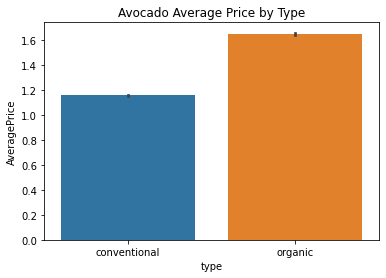

In [8]:
# types of pricing for avocado
plt.figure()
plt.title("Avocado Average Price by Type")
sns.barplot(x="type",y="AveragePrice",data= df)
plt.show()

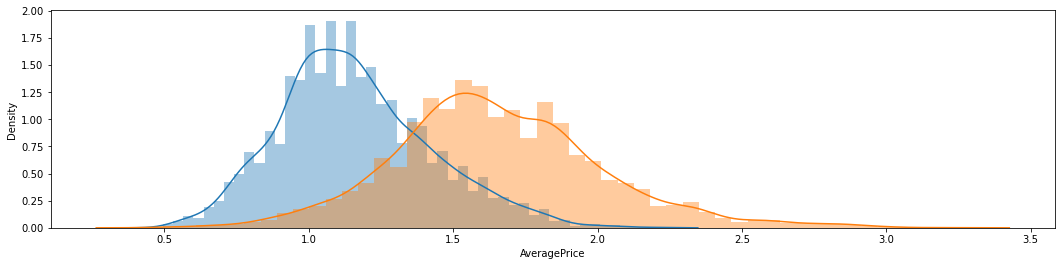

In [9]:
df_conventional = df[df['type'] == 'conventional']
df_organic = df[df['type'] == 'organic']

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
sns.distplot(df_conventional['AveragePrice']) # histogram
sns.distplot(df_organic['AveragePrice']) # histogram
plt.show()

 - From the plot we conclude organic avocado is more expensive

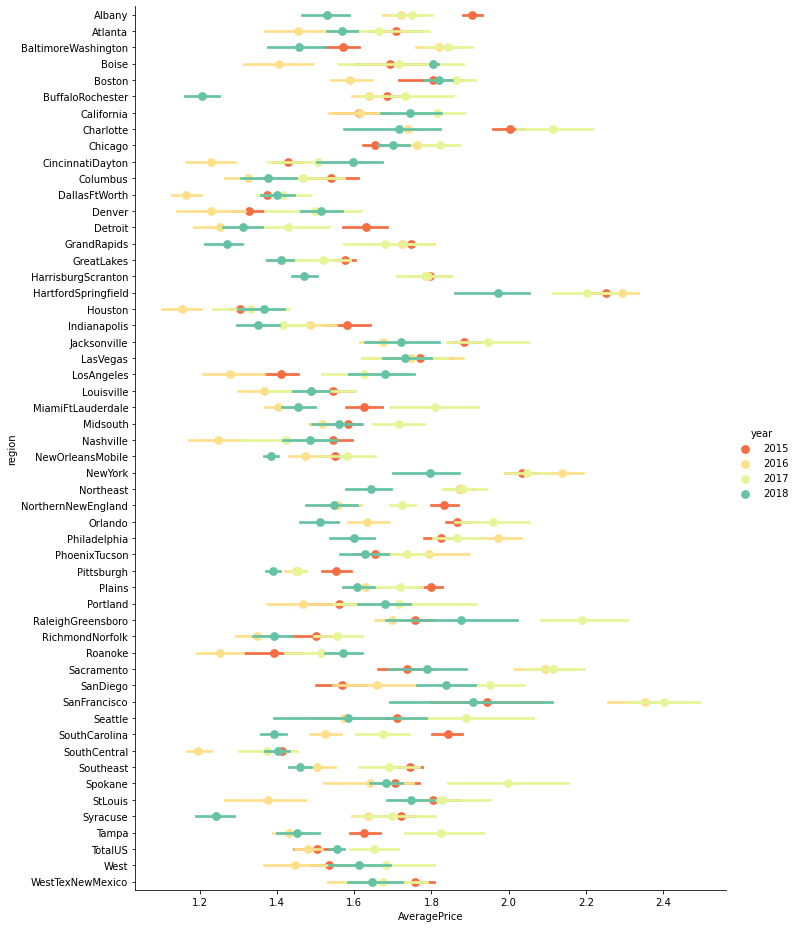

In [10]:
mask = df['type']=='organic'
g = sns.factorplot('AveragePrice','region',data=df[mask],
    hue='year',size=13,aspect=0.8,palette='Spectral',join=False,)

region also affects the avocado pricing

##### 4. What features are the most correlated?

<AxesSubplot:title={'center':'Correlation Matrix'}>

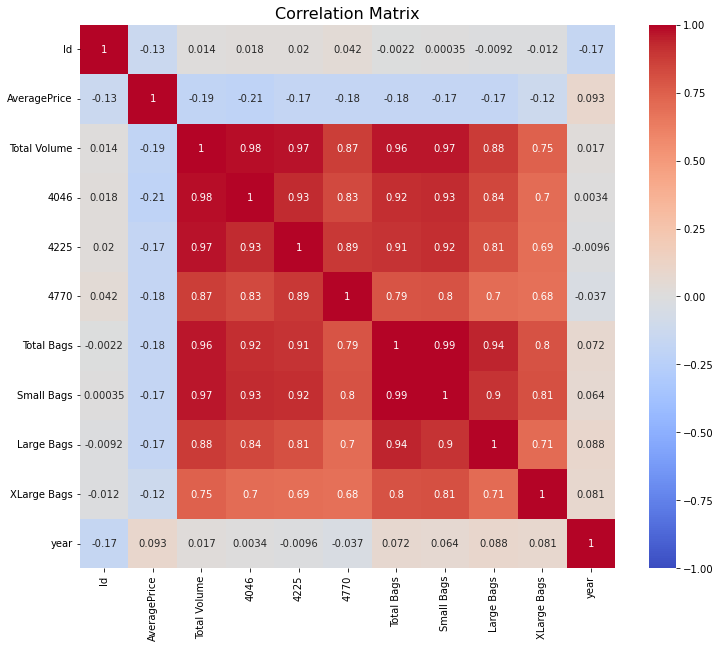

In [11]:
corrmat = df.corr()
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
filter = df.columns != 'id'
sns.heatmap(df[df.columns[filter]].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

Most correlated features:
 - Toatal Bags 
 - Total volume
 - small Bags
 - 4046
 - 4225
  - All the mentioned feature have high correaltions with most of the other features, the highest is
        - Total bags and small bags with 0.99
        - Total volume and 4046 with 0.98
        

In [12]:
# Checking for missing data
print(f"Missing data: {df.isna().sum(axis=0).any()}")

Missing data: False


##### 2. Train and test the data & 3. Perform feature engineering

In [13]:
df['type']= df['type'].map({'conventional':0,'organic':1})

# Extracting month from date column.
df.Date = df.Date.apply(pd.to_datetime)
df['Month'] = df['Date'].apply(lambda x:x.month)
df.drop('Date',axis=1,inplace=True)
df.Month = df.Month.map({1:'JAN',2:'FEB',3:'MARCH',4:'APRIL',5:'MAY',6:'JUNE',7:'JULY',8:'AUG',9:'SEPT',10:'OCT',11:'NOV',12:'DEC'})

In [14]:
# Creating dummy variables
dummies = pd.get_dummies(df[['year','region','Month']],drop_first=True)
df_dummies = pd.concat([df[['Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type']],dummies],axis=1)
target = df['AveragePrice']

# Splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(df_dummies,target,test_size=0.30)

# Standardizing the data
cols_to_std = ['Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags','Large Bags', 'XLarge Bags']
scaler=StandardScaler()
scaler.fit(X_train[cols_to_std])
X_train[cols_to_std] = scaler.transform(X_train[cols_to_std])
X_test[cols_to_std] = scaler.transform(X_test[cols_to_std])

##### 5. Build a model & 6. Use XGBoost

In [15]:
model = XGBRegressor()
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
score = model.score(X_train, y_train)
print('Training Score:', score)
score = model.score(X_test, y_test)
print('Testing Score:', score)
output = pd.DataFrame({'Predicted':Y_pred})

Training Score: 0.9346184650593543
Testing Score: 0.8484502060979879


##### 7. Fine tune the parameters – explain each and every step in detail. Which parameter? Why this value?

In [16]:
# help(xgboost)

Parameters used for tuning:
 - eta: Learning rate, makes the model robust by shrinking the weight on each step
 - min_child_weight: To prevent over fitting, high value may underfit the model.
 - max_depth: maximun depth of the tree.
 - max_leaf_nodes: maximum number of terminal nodes or leaves.
 - gamma: specifies the minimum loss reduction required to make a split.
 - lamda: L2 regularization term on weights
 - objective: for minimizing loss function
 - seed: random number of seed

For 1st model we start with random valus and set 
 - min_child_weight as 2 to reduce overfitting
 - gamma as 2 to regularize the model 

In [17]:
model = XGBRegressor(
    eta =0.01,
    n_estimators=500,
    min_child_weight = 4,
    max_depth=10,
    gamma=2,
    seed=7)

model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
score = model.score(X_train, y_train)
print('Training Score:', score)
score = model.score(X_test, y_test)
print('Testing Score:', score)
output = pd.DataFrame({'Predicted':Y_pred})

Training Score: 0.7528785785152043
Testing Score: 0.733071144316851


Since the result was not satisfactory we try random values
 - increasing the eta for a bit larger steps for global optima
 - increasing the n_estimators to increase the trees in the process
 - reducing the max_depth to control overfitting
 - increasing the seed

In [18]:
model = XGBRegressor(
    eta =0.1,
    n_estimators=1000,
    min_child_weight = 2,
    max_depth=5,
    gamma=0,
    seed=20)

model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
score = model.score(X_train, y_train)
print('Training Score:', score)
score = model.score(X_test, y_test)
print('Testing Score:', score)
output = pd.DataFrame({'Predicted':Y_pred})

Training Score: 0.9640560856004128
Testing Score: 0.8690598116191692


The result was not bad, now
 - we add new parameters like subsample, colsample_bytree and scale_pos_weight for random sampling
 - we set max_depth to 3 and min_child_weight to 7 to see if it can reduce overfiiting

In [19]:
model = XGBRegressor(
    learning_rate =0.1,
     n_estimators=1000,
     max_depth=4,
     min_child_weight=7,
     gamma=0,
     subsample=0.5,
     colsample_bytree=0.5,
     seed=27)

model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
score = model.score(X_train, y_train)
print('Training Score:', score)
score = model.score(X_test, y_test)
print('Testing Score:', score)
output = pd.DataFrame({'Predicted':Y_pred})

Training Score: 0.9256183657272659
Testing Score: 0.8590306349333787


We see there was reduction in overfitting
 - we can now try reducing max_depth and min_child_weight
 - and increase sampling parameters

In [20]:
model = XGBRegressor(
    learning_rate =0.1,
     n_estimators=1000,
     max_depth=3,
     min_child_weight=6,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     scale_pos_weight=1,
     seed=25)

model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
score = model.score(X_train, y_train)
print('Training Score:', score)
score = model.score(X_test, y_test)
print('Testing Score:', score)
output = pd.DataFrame({'Predicted':Y_pred})

Training Score: 0.8931500806063828
Testing Score: 0.8483736655065828


##### 8. Evaluate the performance of your model

In [21]:
mae = np.round(mean_absolute_error(y_test,Y_pred),3)
mse = np.round(mean_squared_error(y_test,Y_pred),3)
score = np.round(r2_score(y_test,Y_pred),3)

print('R2 Score:', score)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)


R2 Score: 0.848
Mean Absolute Error: 0.115
Mean Squared Error: 0.025


- So far the best model is with the accuracy of 84.4, obiviously the previous models has higher testing accuracy but they all had high variance and it may not perform well to the unseen data.
- The MSE is calculated as the mean or average of the squared differences between predicted and expected target values in a dataset and our MSE is 0.025 which is good.
- Also the MAE is 0.115 which also indicates that our model performance was good.

##### 9. Explain in detail what is happening inside your model? How have you built this model?

 - First while data analysis we found the features that affects the avocado price the most, type and region.
 - In feature engineering we converted all the catogorical values into numerical for computation. Created dummies for region and changed the date feature to Month by extracting only the Month from the date column.
 - Then, we split the dataset into train and test and tuned the hyperparameters to the get the best result possible. Hyperparameter tuning are clearly explained in the above section.
 - XGBoost typically implements  gradient boosting decision tree algorithm.
 - Boosting is an ensemble technique where new models are added to correct the errors made by existing models. 
 - Models are added sequentially until no further improvements can be made.
 - So, in our model new models are added which corrects the previous model's errors. And we use hyperparameters to tune the process and get the best results possible.